### Bagging

<p>Bagging is a procedure that let's use bootstrapping to reduce the variance, and ultimately performance, of a prediction. The procedure can be defined as follows:<br><br>
We have data $D=[(X_1, Y_1),(X_2, Y_2),...,(X_N, Y_N)]$ and we want to learn:$\:\: E[Y|X]=\hat{f}(X)$. Define a bootstrap sample $D^b$ as $N$ samples from $D$, sampled with replacement. Let $E^b[Y|X]=\hat{f}^b(X)$ be the function learned from training set $D^b$.
Our bagged prediction is then the mean of all estimates of $f^b(X)$. I.e.,
<br><br>
<center>$\hat{f}_{bag}(X) = \frac{1}{B}\sum\limits_{b=1}^B \:\hat{f}^b(X)$</center>
<br>
This is a relatively straightforward procedure to implement, which we can show on a simulated example.





</p>

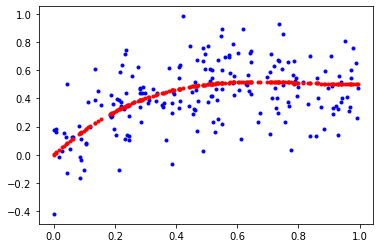

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
# os.chdir("C:/Users/kevin/Documents/GitHub/DS_course/ipython/")
os.chdir("../")
import course_utils as bd
import imp
imp.reload(bd)

#Generate Y, and X, where E[Y|X] is a 3rd order polynomial
betas = [0, 2, -2.5, 1]
n=200
sig=0.2
sp=20

x_init = np.random.uniform(0, 1, n)
e_init = np.random.normal(0, sig, n)

dat = bd.genY(x_init, e_init, betas)
dat = bd.makePolyFeat(dat, 6)

#Plot the data vs. the real curve
plt.plot(dat['x'], dat['y'], 'b.')
plt.plot(dat['x'], dat[['x','x2','x3']].dot(np.array(betas[1:])), 'r.')
plt.show()

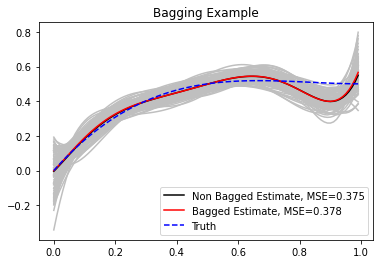

In [2]:
#Now let's do bagged prediction using linear regression
from sklearn import linear_model

n_boots = 100

boot_est = dict()
x_grid = np.arange(0, 1, 0.01)
d_grid = pd.DataFrame(x_grid, columns=['x'])
d_grid = bd.makePolyFeat(d_grid, 6)


fig = plt.figure()

#Generate and plot each bootstrap model
for i in range(n_boots):
    D_b = dat.iloc[np.random.randint(0, dat.shape[0], size=dat.shape[0])]
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(D_b.drop('y', 1), D_b['y'])
    boot_est[i] = regr.predict(d_grid)
    plt.plot(x_grid, boot_est[i], color='0.75')

#Now aggregate the bootstrapped models for a single prediction
bag_est = pd.DataFrame(boot_est).mean(axis=1)

#For comparison, we'll also see what a single fit on the original data looks like
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(dat.drop('y', 1), dat['y'])
non_bag = regr.predict(d_grid)

#Truth
truth = d_grid[['x','x2','x3']].dot(np.array(betas[1:]))

#Now Get MSE of estimates
mse_bag = round(np.sqrt(((truth-bag_est)**2).sum()), 3)
mse_non = round(np.sqrt(((truth-non_bag)**2).sum()), 3)


plt.plot(x_grid, non_bag,'k-', label='Non Bagged Estimate, MSE={}'.format(mse_non))
plt.plot(x_grid, bag_est,'r-', label='Bagged Estimate, MSE={}'.format(mse_bag))
plt.plot(d_grid['x'], d_grid[['x','x2','x3']].dot(np.array(betas[1:])), 'b--', label='Truth')


plt.title('Bagging Example')
plt.legend(loc=4)
plt.show()

<p>We can see in the above example that variance of the bootstrapped predictions is very high, especially around the extreme values of $X$, where there is less data. The goal of Bagging is to reduce the variance of the prediction (and thus improve accuracy). The lever that controls the amount of variance reduction is the number of bootstrap samples used.
<br><br> 
<b>When to use Bagging</b><br><br>
According to the original <a href="http://statistics.berkeley.edu/sites/default/files/tech-reports/421.pdf">Bagging paper</a> by Leo Breiman, bagging will produce a much better reduction in training error when the underlying classifier or regression model is unstable, and sensitive to minor variations of the data $D$. The above example was meant to show Bagging at work. We used a linear regression on polynomial features, and even though the underlying model was misspecified (we used degree 6 where the truth is degree 3), the bagged estimate isn't too far from the estimate without bagging. One must be careful when choosing to use bagging, because it can actually hurt performance if the underlying model is fairly stable (if you rerun the above regression example with different data sets or different bootstrapping iterations, you might find that the bagged MSE is worse).
</p>

## Random Forests
### The Basic Algorithm
<p>The Random Forest algorithm is probably the most well known and utilized implementation of the Bagging technique. A RF is an ensemble of Decision Trees, where both bagging and random feature selection are used to reduce the variance of the forest. The basic algorithm goes as follows:<br><br>
Assume we have a data matrix $D=[X,Y]$ with $N$ records and $M$ features.<br><br>

<i><u>Train</u></i><br>
For each $b$ of $B$ iterations:
<ul>
    <li>Draw a bootstrap sample $D^b$ of size $N$ from $D$.</li>
    <li>Sample $p$ features from $X$, where $p<<M$.</li>
    <li>Grow a Decision Tree $T_b(X)$ on this data</li>
</ul>
<br>
<i><u>Score</u></i><br>
Take the average of all of the tree predictions, i.e.<br>
$RF(x)=\frac{1}{B}\sum\limits_{b=1}^B \: T_b(x)$




</p>

<p>We'll start by building a forest using <a href="http://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble">SKlearn.ensemble</a>. Check out <a href="http://scikit-learn.org/stable/modules/ensemble.html">here</a> for a brief overview of Ensemble methods in Python. We'll also compare this to a single tree. This test is close to an off-the-shelf test, in the sense that we are not doing any intelligent hyper-parameter optimization. However, we do use a few well reasoned starting parameters.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import course_utils as bd
imp.reload(bd)


# f = 'C:/Users/kevin/Documents/GitHub/DS_course/datasets/Cell2Cell_data.csv'
f = 'data/Cell2Cell_data.csv'
dat=pd.read_csv(f, header=0, sep=',')
train, test = bd.trainTest(dat, 0.8)
lab = 'churndep'


#We'll build a RF and compare to a DT
clf_def = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 20)
clf_def = clf_def.fit(train.drop(lab, 1), train[lab])
dt_pred = clf_def.predict_proba(test.drop(lab,1))

rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_def = rf_def.fit(train.drop(lab, 1), train[lab])
rf_pred = rf_def.predict_proba(test.drop(lab,1))


<p>Now compare the forest to the tree using AUC</p>

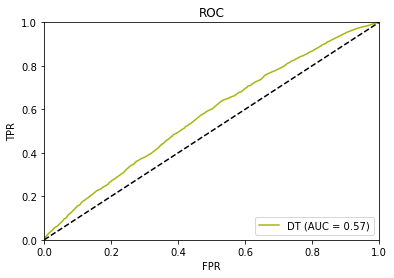

In [4]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import course_utils as bd
imp.reload(bd)


bd.plotAUC(test[lab], dt_pred[:,1], 'DT')
plt.show()


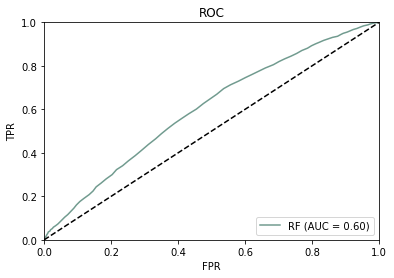

In [5]:
bd.plotAUC(test[lab], rf_pred[:,1], 'RF')
plt.show()

<p>We can see that with little optimization involved, the RF is already a bit better. Let's see how much better we can do with a grid search on both the DT and the RF. We have already covered DT optimization in a different module, so here we'll focus on the input parameters of the RandomForestClassifier object that let us tune the forest.<br><br>

The following two are forest specific:
<ul>
    <li>n_estimators - the number of trees (and bootstrapped samples) to be used</li>
    <li>max_features - the number of features that will be randomly sampled for each tree.</li>
</ul>
The default in RandomForestClassifier is max_features=sqrt(total_features), which is generally a good suggestion. The default for n_estimators is 10, which is probably too low. The other design parameters are specific to the individual decision trees, which are covered in the decision tree module.
</p>

### Out-of-Bag Error
<p>Usually we would want to use cross-validation for performance tuning. For Random Forests, this becomes problematic, as cross-validation with RF's can be painfully slow. That's because each cross-validation step requires building k*n_estimators trees. One advantage of a random forest is that it performs what is called an "out-of-bag" error calculation. Remember that each tree is built from a bootstrap sample of the data, so that for each tree, some portion of the data is not used for that tree. The RF method computes an out-of-bag prediction for each record $[x_i, y_i]$ by averaging the prediction $f^b(x_i,y_i)$ on record $i$ for the bootstrap iterations in which record $i$ was not chosen in the bootstrap. The out-of-bag prediction can then be used to compute out-of-sample error for model selection and validation. This method should be equivalent to $N$-fold cross-validation. 

<br><br>
We'll start by building a tree of oob predictions enabled and then compare the performance to a true hold out set.

</p>

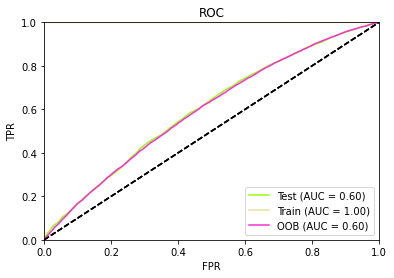

In [6]:
rf_def = RandomForestClassifier(criterion='entropy', n_estimators=100, oob_score=True)
rf_def = rf_def.fit(train.drop(lab, 1), train[lab])
rf_pred_test = rf_def.predict_proba(test.drop(lab,1))
rf_pred_train = rf_def.predict_proba(train.drop(lab,1))

bd.plotAUC(test[lab], rf_pred_test[:,1], 'Test')
bd.plotAUC(train[lab], rf_pred_train[:,1], 'Train')
bd.plotAUC(train[lab], rf_def.oob_decision_function_[:,1], 'OOB')
plt.show()

<p>We can see two very important things here. 
<ul>
    <li>The training AUC is 1.00. This means that the RF perfectly predicts the training set!</li>
    <li>The OOB AUC is exactly equal to the test AUC up to 2 digits of precision.</li>
</ul>
Now we'll use OOB error to do model selection.

In [7]:
n_est = [50, 100, 200, 500, 1000]
m_feat = [1, 3, 6, 11]

aucs_oob = {}
aucs_test = {}

for m in m_feat:
    aucs_oob[m] = []
    aucs_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='entropy', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(train.drop(lab, 1), train[lab])
        aucs_oob[m].append(roc_auc_score(train[lab], rf_oob.oob_decision_function_[:,1]))
        aucs_test[m].append(roc_auc_score(test[lab], rf_oob.predict_proba(test.drop(lab,1))[:,1]))

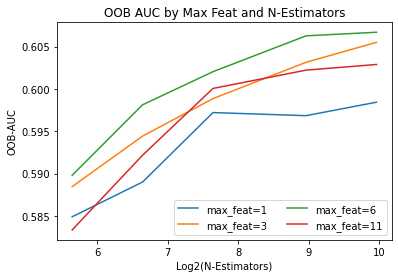

In [8]:
#We'll plot in this block

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_oob[m], label='max_feat={}'.format(m))
    
plt.title('OOB AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('OOB-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

<p>We can see in the plot above that the forest gets better with more trees, but we see that this effect tapers off asymptotically. We also see somewhat of a Golidlocks phenomenon with respect to the optimal number of features. Having too few features is suboptimal (i.e., max_feat=1), probably due to high bias in the trees. Conversely, having too many features (max_feat=11) is also bad, and this is because the individual trees are too correlated with each other, which prevents the Bagging approach from reducing the overall variance (see the analysis below to understand the math behind this statement). The right number of features is in the middle. We see that choosing $3$ or $6$ perform relatively the same. $3$ happens to be closer to the good heuristic default, which is max_feat=sqrt(total feats). 
<br><br>
Next, for the purpose of educating ourselves, we'll also look at the Test set AUC's on each of the design options above.
</p>

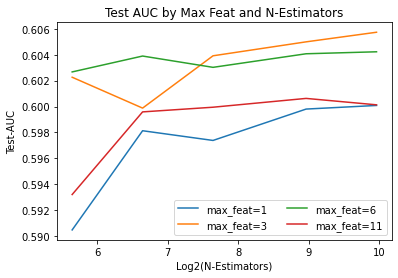

In [9]:
x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_test[m], label='max_feat={}'.format(m))
    
plt.title('Test AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Test-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

<p>We can see similar patterns in the true holdout evaluation as we did in the OOB evaluation. We also tend to see a few more things. For one thing, having more trees actually hurts the performance for some levels of max_feat. We also see that the best choice for max_feat was indeed $3$.


</p>

### Feature Importance
<p>Much like with Decision Trees, the Random Forest Classifier has a built in mechanism for evaluating feature importance. Quoting the sklearn documentation:<br><br> 

<i>Features used at the top of the tree contribute to the final prediction of a larger fraction of the input samples. The <b>expected fraction of the samples</b> they contribute to can thus be used as an estimate of the <b>relative importance of the features</b>.</i>
<br><br>
The above computation is made for each feature in each tree and then averaged over all trees in the forest. The Random Forest Classifier returns an attribute with an importance score for each feature, and these scores sum to $1$ across all features.
<br><br>
We'll train a RF on the best options found above and then look at the feature importances.

</p>

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(criterion='entropy', n_estimators=500)
rf_best = rf_best.fit(train.drop(lab, 1), train[lab])

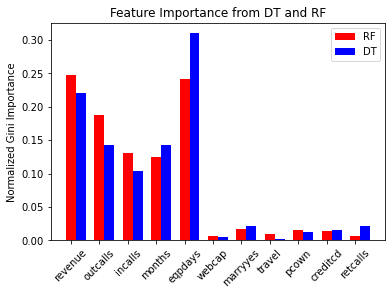

In [11]:
%matplotlib inline

cols = train.drop(lab, 1).columns.values
rf_fi = rf_best.feature_importances_
dt_fi = clf_def.feature_importances_

fig, ax = plt.subplots()
width=0.35

ax.bar(np.arange(len(cols)), rf_fi, width, color='r', label='RF')
ax.bar(np.arange(len(cols))+width, dt_fi, width, color='b', label='DT')

ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45)
plt.title('Feature Importance from DT and RF')
ax.set_ylabel('Normalized Gini Importance')
plt.legend(loc=1)


### Why do Random Forests work?
<p>We can show with a little algebra why Random Forests lead to generally better estimation performance.<br><br> Let's say that the variance of a single tree of size $N$ and $p$ features is: $Var(T_b(X))=\sigma^2$. Similarly the variance of the Random Forest is the variance of the sum of such trees, i.e., $Var(RF(X))=Var(\frac{1}{B}\sum\limits_{b=1}^B \: T_b(X)).$ Because the invidual trees are trained with overlapping records and features, the individual tree estimates are correlated. Thus, the variance does not factor completely cleanly into a sum of individual tree variances. We'll solve this by using the following relation:<br><br>

<center>$Var(\frac{1}{B}\sum\limits_{b=1}^B \: T_b(X))=\frac{1}{B^2}\sum\limits_{i=1}^B\sum\limits_{j=1}^B\:Cov(T_i(X), T_j(X))$</center>

<center>$=\frac{1}{B^2}\sum\limits_{i=1}^B (\sum\limits_{i \neq j}\:Cov(T_i(X), T_j(X))+Var(T_i(X))$</center><br><br>
If $\rho$ is the correlationb etween $T_i(X)$ and $T_j(X)$, then $Cov(T_i(X), T_j(X))=\rho\sigma^2$. So then:<br><br>

<center>$Var(\frac{1}{B}\sum\limits_{b=1}^B \: T_b(X))=\frac{1}{B^2}\sum\limits_{i=1}^B ((B-1)\rho\sigma^2+\sigma^2)=\frac{1}{B}((B-1)\rho\sigma^2+\sigma^2)=\rho\sigma^2+\frac{1}{B}(1-\rho)\sigma^2$</center><br><br>
This last quantity shows the two factors that reduce the variance of the Random Forest. 1). The term $\rho\sigma^2$ shrinks to $0$ as the correlation between trees reduces to $0$, which is achieved by randomly downsampling the features. 2). The right-hand term shinks asymptotically to $0$ as $B$ increases.

</p>